In [187]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rcParams
import scipy.stats as stats 
import matplotlib.ticker as plticker
from scipy.optimize import curve_fit

In [193]:
DAQ = pd.read_csv('DA-QCalc.csv')
measured = DAQ.loc[0:9,'Q L/s']
predicted = DAQ.loc[0:9,'Predicted Q']

In the field season of June 2016 there was much lower than average rainfall in Puerto Rico and the river stage was at baseflow levels. 

We directly measured discharges from 9 channels with a salt plug as an injection tracer. Four of the 9 channels were formed by sapping erosion and had no signs of overland flow contributions. With these measurements we were able to capture drainage areas ranging from 3367 km2 to 9.45 km2. I use discharge from the Rio Icacos stream gage to bring the number of observations up to 10 watersheds.

I plotted the drainage areas for each measurement vs. the discharge. I fit the data with a linear regression function from excel. I set the intercept of this function manually to 0, thinking that you cannot have negative discharge. The slope of the line is 0.00006 and it’s r2 value is 0.83174

Then I use the same simple linear regression to predict the discharge for the channels with observed discharge. 

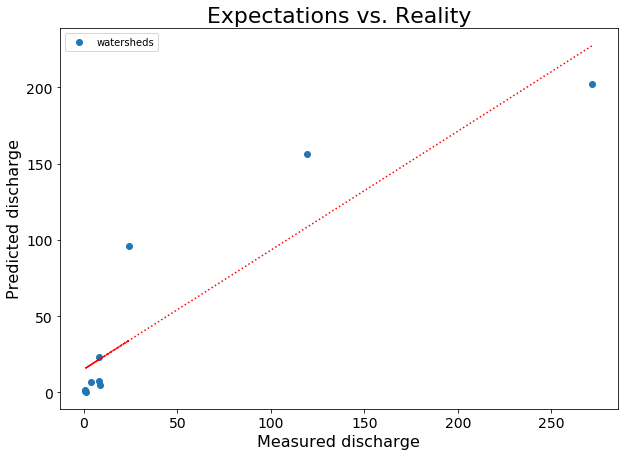

In [196]:
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(measured,predicted, marker='o', linestyle='', label='watersheds')

# calc the trendline
z = np.polyfit(measured, predicted, 1)
p = np.poly1d(z)
plt.plot(measured,p(measured),"r:")

ax.set_xlabel('Measured discharge')
ax.set_ylabel('Predicted discharge')
ax.set_title('Expectations vs. Reality')

plt.legend()

plt.show()

**Residuals plots? New model using non-linear fits?**

I think you can run the same model multiple times on subsets of the data and see what the distribution of residuals is. Do this a bunch of times to reduce the variance between the obervations and the predications and get the best fit to the model? Then use that instead to predict the discharge in the other watersheds, like below:

I took the equation and used it to predict the discharge of 48 other channels for which I have measured the drainage area and the minimum eroded volume. All of these channels are carved by sapping erosion, and verified in the field. 

The chart below plots the drainage area vs. the discharge (predicted and measured) for all 58 channels under baseflow conditions. The linear regression plotted for this data was performed with the scipy linear regression function. Equation and r2 are displayed on the chart.

In [164]:
x = DAQ['DA m^2']/1000
y = DAQ['Q L/s']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r-squared: %f" % r_value**2)

slope: 0.061332    intercept: -1.126147
r-squared: 0.864645


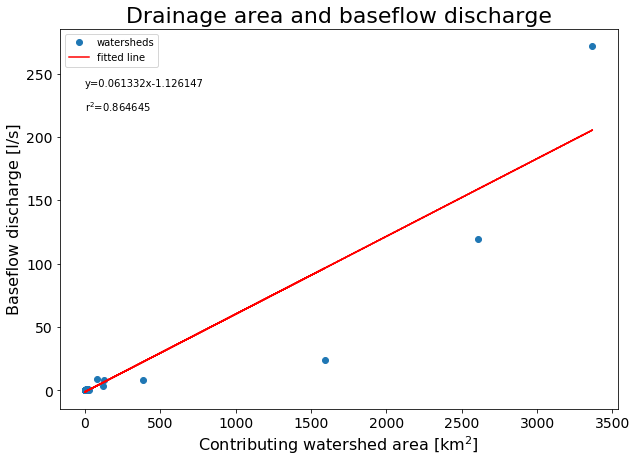

In [165]:
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x,y, marker='o', linestyle='', label='watersheds')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r:")

ax.set_xlabel('Contributing watershed area [km$^2$]')
ax.set_ylabel('Baseflow discharge [l/s]')
ax.set_title('Drainage area and baseflow discharge')

plt.annotate('y=0.061332x-1.126147', xy=(0, 240))
plt.annotate('r$^2$=0.864645', xy=(0, 220))

plt.legend()

plt.savefig('DrainageArea_MeasuredDischarge.jpg')
plt.show()

Definitely looks like an exponential fit would be better. 

**COSMO DATA**

In [166]:
cosmo = pd.read_csv('Cosmo_plot.csv')
cosmo.dropna()
cosmo

,ID,Erosion rate,uncertainty,DA,[10Be],Q
0,IC-GW2,84.96,7.16,27.150,134982.87720,0.684314
1,IC-GW1,131.43,10.20,82.450,88491.22874,8.662133
2,Sab-GW8,40.01,3.25,11.495,287066.56680,0.000690
3,Sab-GW9,42.96,3.45,10.079,268924.36270,0.000605
4,Sab-GW16,62.43,4.99,38.882,185315.29520,0.002333


Q for IC-GW2 and IC-GW1 are measured. The rest are predicted. The predictions **need to be** be improved.

I was thinking that we have [10Be] erosion rate data for the Icacos at the gage and Rio Sabana from above the kp. There might even be other [10Be] measurements for matching sub-watersheds, I'd have to check. Those erosion rates *shouldn't* be reflective of just the baseflow discharge. They should average out the whole suite of fluvial and hillslope processes. 

Is there a way to look at how these might differ? Like, how the erosion rate in the fluvial channel is different than the erosion rate in the sapping channel?

In [167]:
e = cosmo['Erosion rate']
d = cosmo['DA']
q = cosmo['Q']

Adding the cosmo rates to the Q vs. DA plot doesn't work. The variation in drainage are for the channels with cosmo erosion rates is super small and it just plots like a straight line over basically 0 drainage area.

**Tried this function**
def func(x, a, c):
     return a * np.exp(x) + c
popt, pcov = curve_fit(func, e, q)
popt
array([7.07280224e-57, 1.71985278e-01])

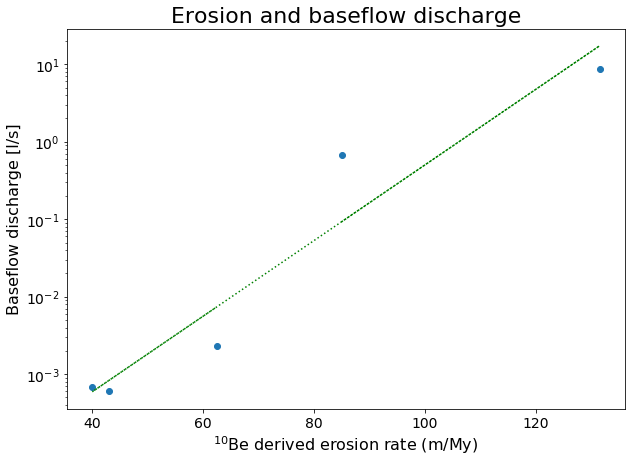

In [185]:
#Add in cosmo erosion rates
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(e,q, marker='o', linestyle='', label='watersheds')
ax.set_yscale('log')

p = np.polyfit(e, np.log(q), 1)
ax.semilogy(e, np.exp(p[0] * e + p[1]), 'g:')

ax.set_xlabel('$^{10}$Be derived erosion rate (m/My)')
ax.set_ylabel('Baseflow discharge [l/s]')
ax.set_title('Erosion and baseflow discharge')

plt.show()

**From stackoverflow**
If you fit the logarithm of the data to a line, you need to invert this operation when actually plotting the fitted data. 
I.e. if you fit a line to np.log(y), you need to plot np.exp(fit_result).